# Libraries

In [1]:
#Here we import all the necessary libraries

import tensorflow as tf
import numpy as np
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import imageio.v2 as imageio
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

# Loading, splitting and preprocessing data

In [2]:
#With this code we create two lists containing the exact path to reach every image in our local database

image_path = "DentalPanoramicXrays\\Images\\"
mask_path = "DentalPanoramicXrays\\Segmentation1\\"
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [3]:
#Check if everything is okay: we should read the same number of images for both

print(len(image_list))
print(len(mask_list))

116
116


Text(0.5, 1.0, 'Segmentation')

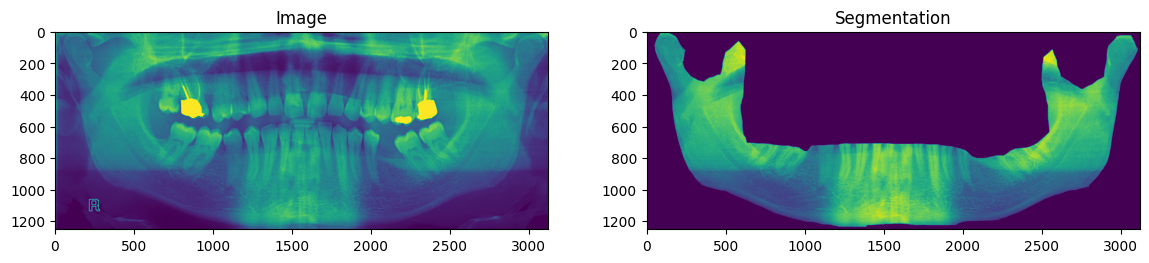

In [4]:
#With this code we can visualize the images. Change N to switch to a different image.

N = 104
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :])
arr[1].set_title('Segmentation')

In [5]:
#We create two TensorFlow datasets (image_list_ds and mask_list_ds) containing file paths from the two lists.

image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

#This is to see what the dataset is like for both image and mask
for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\glauc\\Desktop\\Wisdom Tooth\\DentalPanoramicXrays\\Images\\1.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\glauc\\Desktop\\Wisdom Tooth\\DentalPanoramicXrays\\Segmentation1\\1.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\glauc\\Desktop\\Wisdom Tooth\\DentalPanoramicXrays\\Images\\10.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\glauc\\Desktop\\Wisdom Tooth\\DentalPanoramicXrays\\Segmentation1\\10.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\glauc\\Desktop\\Wisdom Tooth\\DentalPanoramicXrays\\Images\\100.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'C:\\Users\\glauc\\Desktop\\Wisdom Tooth\\DentalPanoramicXrays\\Segmentation1\\100.png'>)


In [6]:
# Create a dataset from the two lists 

image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1): # printing the first element of the dataset
    print(image)
    print(mask)

tf.Tensor(b'C:\\Users\\glauc\\Desktop\\Wisdom Tooth\\DentalPanoramicXrays\\Images\\1.png', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\glauc\\Desktop\\Wisdom Tooth\\DentalPanoramicXrays\\Segmentation1\\1.png', shape=(), dtype=string)


In [7]:

def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path) #Reads the image file from image_path.
    img = tf.image.decode_png(img, channels=1) #We have a single channel as the images are black and white.
    img = tf.image.convert_image_dtype(img, tf.float32) # Decodes the image into a tensor and converts its data type to tf.float32. 
    mask = tf.io.read_file(mask_path) #Reads the mask file from mask_path.
    mask = tf.image.decode_png(mask, channels=1) #Decodes the mask into a tensor
    return img, mask #Returns the processed image tensor (img) and the processed mask tensor (mask).


#We then ensure that all input images and masks are of the same size. Our NN expects inputs to have consistent dimensions.
#However, we are loosing quality.

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    # input_image = input_image / 255. Temporary removed

    return input_image, input_mask

In [10]:
#We apply the preprocess function to each processed image and mask pair in the image_ds dataset, resulting in a dataset of preprocessed image and mask pairs


image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [28]:
# Define a function to calculate min and max pixel values
def calculate_min_max(dataset):
    min_value = 255.0  # Initialize min_value to the maximum possible pixel value
    max_value = 0.0     # Initialize max_value to the minimum possible pixel value

    # Iterate through the dataset to find min and max pixel values
    for image, mask in dataset:
        image_min = tf.reduce_min(image)
        image_max = tf.reduce_max(image)
        
        min_value = tf.minimum(min_value, image_min)
        max_value = tf.maximum(max_value, image_max)

    return min_value, max_value

# Call the function to calculate min and max pixel values
image_min, image_max = calculate_min_max(processed_image_ds)

print("Min pixel value:", image_min)
print("Max pixel value:", image_max)


Min pixel value: tf.Tensor(0.0, shape=(), dtype=float32)
Max pixel value: tf.Tensor(1.0, shape=(), dtype=float32)


# Encoder

In [12]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:

+       inputs -- Input tensor

        n_filters -- Number of filters for the convolutional layers

        dropout_prob -- Dropout probability. The dropout probability refers to the fraction of input units to drop during training. 
                        It is a parameter that controls the intensity of dropout regularization applied to a neural network model.

                        Dropout is a regularization technique commonly used in neural networks to prevent overfitting.
                        During training, dropout randomly sets a fraction of the input units to 0 at each update. This means that the output of those units, 
                        as well as their corresponding weights, are not considered during the forward and backward passes of training.
                        By randomly dropping units, dropout prevents units from co-adapting too much. This encourages the network to learn more robust 
                        features that are useful across different parts of the input space.

        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
        
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, #Conv2D: This is a class in the Keras library used to create a convolutional layer for a neural network. 
                  3,# filter size   
                  activation='relu',
                  padding='same', #the output feature map will have the same spatial dimensions as the input.
                  kernel_initializer= 'he_normal')(inputs) #the weights are initialized with a normal distribution centered around 0.
    

    # Here, conv represents the output of the first convolutional layer. So, this code is stacking another convolutional layer on top 
    # of the previous one. The purpose of stacking multiple convolutional layers is to allow the network to learn increasingly complex 
    # features from the input data. Each subsequent layer can learn to detect higher-level features by combining features learned in previous layers.
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

# Decoder

In [14]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,  # number of filters
                 3, # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3) 
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    return conv

# U-Net Model

In [15]:
def unet_model(input_size=(96, 128, 1), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1) 
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [16]:
img_height = 96
img_width = 128
num_channels = 1

unet = unet_model((img_height, img_width, num_channels))

In [17]:
img_height = 96
img_width = 128
num_channels = 1

unet = unet_model((img_height, img_width, num_channels))

In [18]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 96, 128, 1)]         0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 96, 128, 32)          320       ['input_2[0][0]']             
                                                                                                  
 conv2d_21 (Conv2D)          (None, 96, 128, 32)          9248      ['conv2d_20[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 48, 64, 32)           0         ['conv2d_21[0][0]']           
 g2D)                                                                                       

In [19]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(1300, 3100, 1)


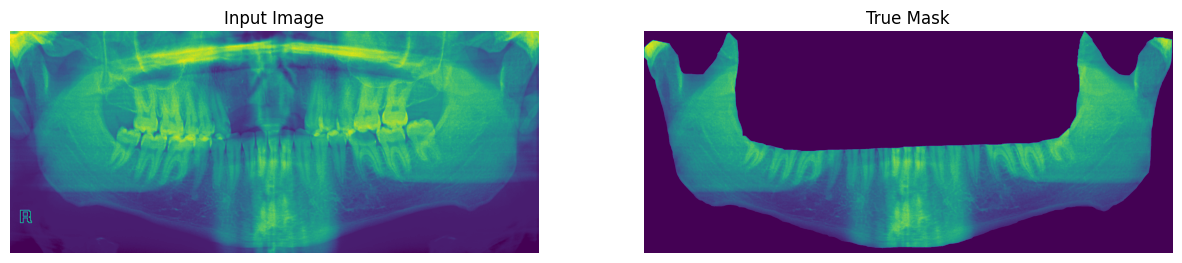

In [21]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


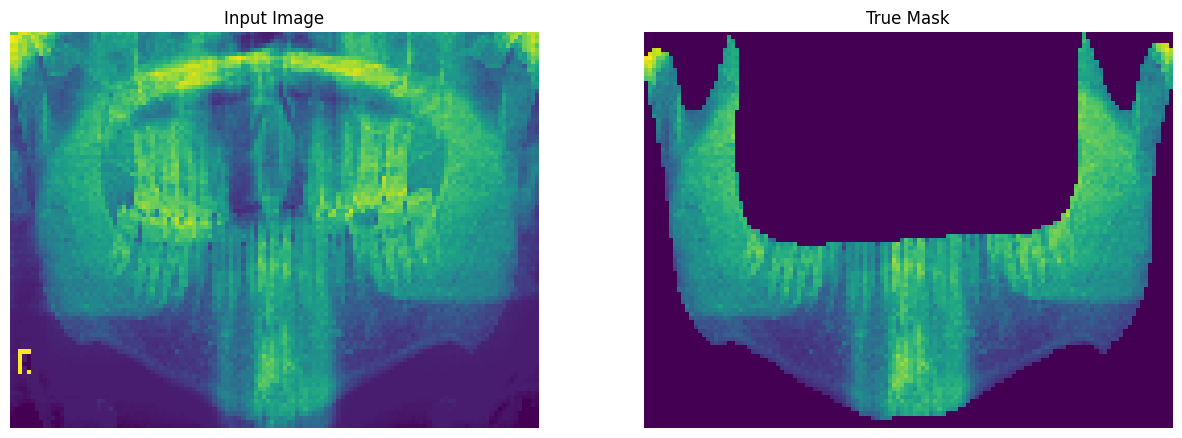

In [22]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

I'm encountering a gigantic error in the training cell. Here are a list of attempts to solve it.

In [29]:
#Check Number of Classes: Ensure that the number of classes in your output layer matches the number of unique labels in your dataset. 
#For sparse_categorical_crossentropy, the labels are expected to be integer values representing the class index.

# Access the labels from your dataset
labels = []  # Assuming labels are stored in a list or array

# Iterate through your dataset to collect unique labels
for image, label in processed_image_ds:  # Assuming processed_image_ds contains your dataset
    labels.extend(label.numpy().flatten().tolist())  # Assuming labels are tensors

# Convert the list of labels to a set to get unique values
unique_labels = set(labels)

# Count the number of unique labels (which corresponds to the number of classes)
num_classes = len(unique_labels)

print("Number of classes:", num_classes)


Number of classes: 255


In [30]:
# Here we change the mask into two possible values: 0 and 1

def translate_nonzero_to_1(image, mask):
    # Translate every nonzero value in the mask to 1
    mask = tf.where(mask != 0, 1, 0)
    return image, mask

# Apply the transformation to your dataset
processed_image_ds_transformed = processed_image_ds.map(translate_nonzero_to_1)


In [33]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds_transformed.batch(BATCH_SIZE)
train_dataset = processed_image_ds_transformed.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds_transformed.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.int32, name=None))
Epoch 1/40
4/4 [==============================] - 14s 2s/step - loss: 3.0914 - accuracy: 0.1054
Epoch 2/40
4/4 [==============================] - 7s 2s/step - loss: 2.4275 - accuracy: 0.4723
Epoch 3/40
4/4 [==============================] - 8s 2s/step - loss: 1.3317 - accuracy: 0.4963
Epoch 4/40
4/4 [==============================] - 7s 2s/step - loss: 0.8398 - accuracy: 0.5132
Epoch 5/40
4/4 [==============================] - 7s 2s/step - loss: 0.7454 - accuracy: 0.5140
Epoch 6/40
4/4 [==============================] - 8s 2s/step - loss: 0.7097 - accuracy: 0.5227
Epoch 7/40
4/4 [==============================] - 8s 2s/step - loss: 0.7003 - accuracy: 0.5344
Epoch 8/40
4/4 [==============================] - 7s 2s/step - loss: 0.6780 - accuracy: 0.5537
Epoch 9/40
4/4 [==============================] - 7s 2s/step - loss: 0.6602 - accuracy: 0.5987
Epoch 10/40
4/4 [======

In [34]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

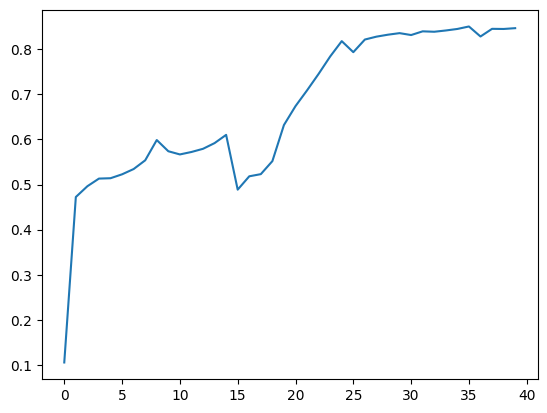

In [35]:
plt.plot(model_history.history["accuracy"])

In [36]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 920ms/step


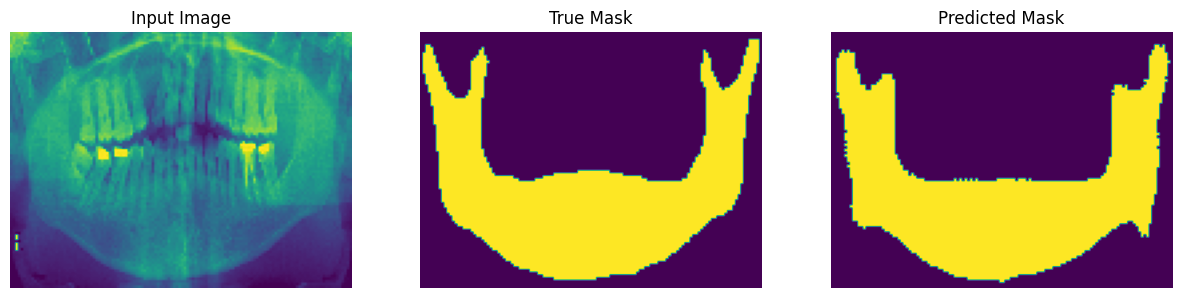

1/1 [==============================] - 0s 393ms/step


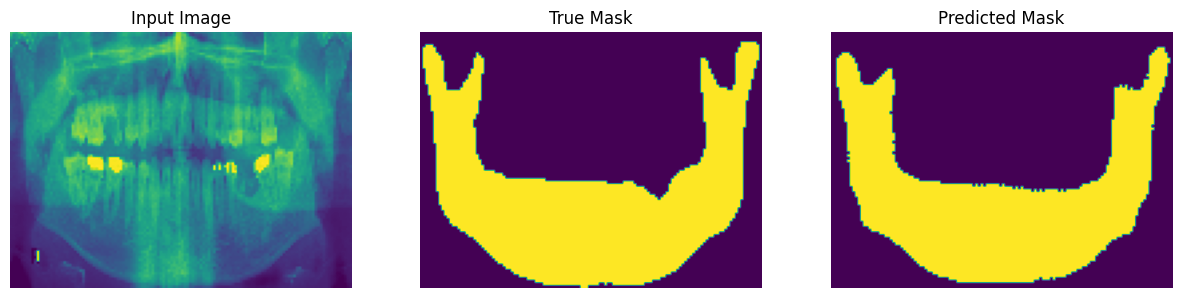

1/1 [==============================] - 0s 400ms/step


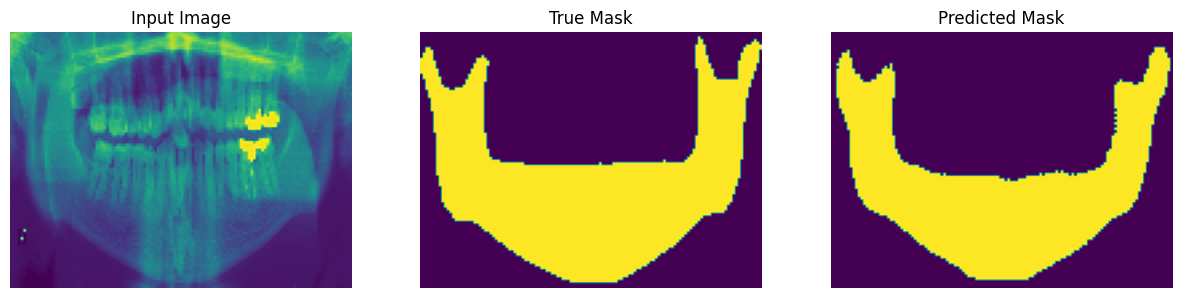

1/1 [==============================] - 1s 508ms/step


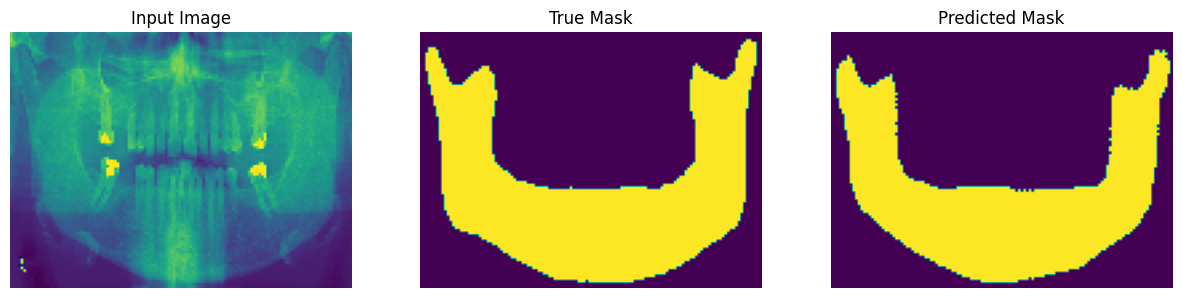

In [37]:
show_predictions(train_dataset, 6)